# Petru și Lupul: Introducere în Învățarea prin Recompensă

În acest tutorial, vom învăța cum să aplicăm învățarea prin recompensă la o problemă de găsire a traseului. Contextul este inspirat de povestea muzicală [Petru și Lupul](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) a compozitorului rus [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Este o poveste despre tânărul pionier Petru, care curajos iese din casă spre poiana din pădure pentru a urmări lupul. Vom antrena algoritmi de învățare automată care îl vor ajuta pe Petru să exploreze zona înconjurătoare și să construiască o hartă optimă de navigare.

Mai întâi, să importăm câteva biblioteci utile:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Prezentare generală a Învățării prin Recompensă

**Învățarea prin Recompensă** (RL) este o tehnică de învățare care ne permite să descoperim un comportament optim al unui **agent** într-un anumit **mediu**, rulând numeroase experimente. Un agent în acest mediu ar trebui să aibă un **scop**, definit printr-o **funcție de recompensă**.

## Mediul

Pentru simplitate, să considerăm lumea lui Peter ca fiind o tablă pătrată de dimensiune `width` x `height`. Fiecare celulă din această tablă poate fi:
* **teren**, pe care Peter și alte creaturi pot merge
* **apă**, pe care, evident, nu poți merge
* **un copac** sau **iarbă** - un loc unde te poți odihni
* **un măr**, care reprezintă ceva ce Peter ar fi încântat să găsească pentru a se hrăni
* **un lup**, care este periculos și ar trebui evitat

Pentru a lucra cu mediul, vom defini o clasă numită `Board`. Pentru a nu aglomera prea mult acest notebook, am mutat tot codul necesar pentru a lucra cu tabla într-un modul separat numit `rlboard`, pe care îl vom importa acum. Poți arunca o privire în acest modul pentru a înțelege mai bine detaliile interne ale implementării.


In [2]:
from rlboard import *

Să creăm acum o tablă aleatorie și să vedem cum arată:


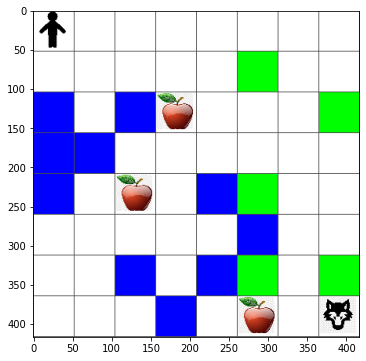

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Acțiuni și Politică

În exemplul nostru, scopul lui Peter ar fi să găsească un măr, evitând în același timp lupul și alte obstacole. Pentru a face acest lucru, el poate, practic, să se plimbe până găsește un măr. Astfel, din orice poziție, el poate alege între una dintre următoarele acțiuni: sus, jos, stânga și dreapta. Vom defini aceste acțiuni ca un dicționar și le vom asocia perechi de modificări corespunzătoare ale coordonatelor. De exemplu, deplasarea spre dreapta (`R`) ar corespunde perechii `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategia agentului nostru (Peter) este definită de ceea ce numim **politică**. Să luăm în considerare cea mai simplă politică, numită **plimbare aleatorie**.

## Plimbare aleatorie

Să rezolvăm mai întâi problema noastră implementând o strategie de plimbare aleatorie.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Să rulăm experimentul de plimbare aleatorie de mai multe ori și să vedem numărul mediu de pași făcuți:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Funcția de Recompensă

Pentru a face politica noastră mai inteligentă, trebuie să înțelegem care mișcări sunt „mai bune” decât altele.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Învățare Q

Construiește un Q-Table sau un tablou multidimensional. Deoarece tabla noastră are dimensiunile `width` x `height`, putem reprezenta Q-Table printr-un tablou numpy cu forma `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Treceți tabelul Q către funcția de plotare pentru a vizualiza tabelul pe tablă:


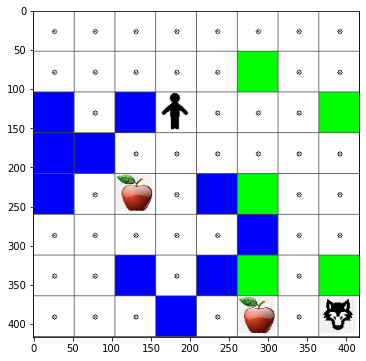

In [9]:
m.plot(Q)

## Esența Q-Learning: Ecuația Bellman și Algoritmul de Învățare

Scrie un pseudo-cod pentru algoritmul nostru de învățare:

* Inițializează tabelul Q, Q, cu valori egale pentru toate stările și acțiunile
* Setează rata de învățare $\alpha\leftarrow 1$
* Repetă simularea de mai multe ori
   1. Începe de la o poziție aleatorie
   1. Repetă
        1. Selectează o acțiune $a$ în starea $s$
        2. Execută acțiunea mutându-te într-o nouă stare $s'$
        3. Dacă întâlnim condiția de sfârșit de joc sau recompensa totală este prea mică - ieși din simulare  
        4. Calculează recompensa $r$ în noua stare
        5. Actualizează funcția Q conform ecuației Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Actualizează recompensa totală și scade $\alpha$.

## Exploatare vs. Explorare

Cea mai bună abordare este să echilibrăm între explorare și exploatare. Pe măsură ce învățăm mai multe despre mediul nostru, vom fi mai predispuși să urmăm ruta optimă, însă, ocazional, să alegem o cale neexplorată.

## Implementare în Python

Acum suntem pregătiți să implementăm algoritmul de învățare. Înainte de asta, avem nevoie de o funcție care să transforme numerele arbitrare din tabelul Q într-un vector de probabilități pentru acțiunile corespunzătoare:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Adăugăm o cantitate mică de `eps` la vectorul original pentru a evita împărțirea la 0 în cazul inițial, când toate componentele vectorului sunt identice.

Algoritmul de învățare propriu-zis pe care îl vom rula pentru 5000 de experimente, numite și **epoci**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

După executarea acestui algoritm, tabelul Q ar trebui să fie actualizat cu valori care definesc atractivitatea diferitelor acțiuni la fiecare pas. Vizualizați tabelul aici:


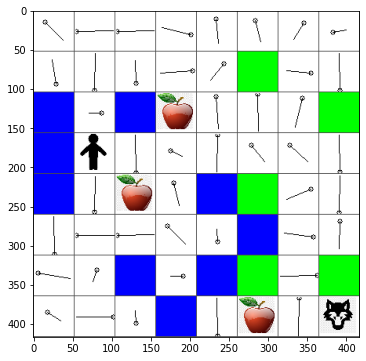

In [12]:
m.plot(Q)

## Verificarea Politicii

Deoarece Q-Table listează „atractivitatea” fiecărei acțiuni în fiecare stare, este destul de simplu să o folosim pentru a defini navigarea eficientă în lumea noastră. În cel mai simplu caz, putem pur și simplu să selectăm acțiunea corespunzătoare valorii celei mai mari din Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Dacă încerci codul de mai sus de mai multe ori, vei observa că uneori pur și simplu "se blochează" și trebuie să apeși butonul STOP în notebook pentru a-l întrerupe.

> **Sarcina 1:** Modifică funcția `walk` pentru a limita lungimea maximă a traseului la un anumit număr de pași (de exemplu, 100) și observă cum codul de mai sus returnează această valoare din când în când.

> **Sarcina 2:** Modifică funcția `walk` astfel încât să nu se întoarcă în locurile unde a fost deja anterior. Acest lucru va preveni ca `walk` să intre într-un ciclu, însă agentul poate ajunge totuși să fie "blocat" într-o locație din care nu poate scăpa.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


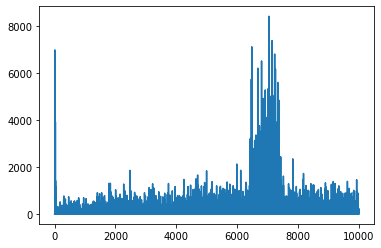

In [15]:
plt.plot(lpath)

Ceea ce observăm aici este că, la început, lungimea medie a traseului a crescut. Acest lucru se datorează probabil faptului că, atunci când nu știm nimic despre mediu, avem tendința să ne blocăm în stări nefavorabile, cum ar fi apa sau lupul. Pe măsură ce învățăm mai multe și începem să folosim aceste cunoștințe, putem explora mediul pentru o perioadă mai lungă, dar încă nu știm bine unde se află merele.

Odată ce învățăm suficient, devine mai ușor pentru agent să atingă obiectivul, iar lungimea traseului începe să scadă. Totuși, suntem încă deschiși explorării, așa că deseori ne abatem de la cel mai bun traseu și explorăm opțiuni noi, ceea ce face ca traseul să fie mai lung decât optimul.

De asemenea, observăm pe acest grafic că, la un moment dat, lungimea a crescut brusc. Acest lucru indică natura stochastică a procesului și faptul că, la un moment dat, putem "strica" coeficienții din Q-Table, suprascriindu-i cu valori noi. Acest lucru ar trebui ideal minimizat prin reducerea ratei de învățare (adică, spre sfârșitul antrenamentului ajustăm valorile din Q-Table doar cu o valoare mică).

În general, este important să ne amintim că succesul și calitatea procesului de învățare depind semnificativ de parametri, cum ar fi rata de învățare, reducerea ratei de învățare și factorul de discount. Aceștia sunt adesea numiți **hiperparametri**, pentru a-i distinge de **parametri** pe care îi optimizăm în timpul antrenamentului (de exemplu, coeficienții din Q-Table). Procesul de găsire a celor mai bune valori pentru hiperparametri se numește **optimizarea hiperparametrilor** și merită o discuție separată.


## Exercițiu
#### O lume mai realistă pentru Petru și lupul

În situația noastră, Petru a putut să se deplaseze aproape fără să obosească sau să îi fie foame. Într-o lume mai realistă, el trebuie să se așeze și să se odihnească din când în când, și de asemenea să se hrănească. Să facem lumea noastră mai realistă implementând următoarele reguli:

1. Prin deplasarea dintr-un loc în altul, Petru pierde **energie** și acumulează **oboseală**.
2. Petru poate câștiga mai multă energie mâncând mere.
3. Petru poate scăpa de oboseală odihnindu-se sub copac sau pe iarbă (adică mergând într-o locație de pe tablă care are un copac sau iarbă - câmp verde).
4. Petru trebuie să găsească și să omoare lupul.
5. Pentru a omorî lupul, Petru trebuie să aibă anumite niveluri de energie și oboseală, altfel pierde lupta.

Modifică funcția de recompensă de mai sus conform regulilor jocului, rulează algoritmul de învățare prin întărire pentru a învăța cea mai bună strategie de câștig al jocului și compară rezultatele plimbării aleatorii cu algoritmul tău în termeni de număr de jocuri câștigate și pierdute.

> **Note**: Este posibil să fie nevoie să ajustezi hiperparametrii pentru ca algoritmul să funcționeze, în special numărul de epoci. Deoarece succesul jocului (lupta cu lupul) este un eveniment rar, te poți aștepta la un timp de antrenare mult mai lung.



---

**Declinarea responsabilității**:  
Acest document a fost tradus folosind serviciul de traducere AI [Co-op Translator](https://github.com/Azure/co-op-translator). Deși depunem eforturi pentru a asigura acuratețea, vă rugăm să rețineți că traducerile automate pot conține erori sau inexactități. Documentul original în limba sa nativă ar trebui considerat sursa autoritară. Pentru informații critice, se recomandă traducerea profesională realizată de un specialist uman. Nu ne asumăm răspunderea pentru eventualele neînțelegeri sau interpretări greșite care pot apărea din utilizarea acestei traduceri.
